## Препроцессинг

In [56]:
from glob import glob
import numpy as np
import pandas as pd
import os
import shutil 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [58]:
labels = []
images = []
for cultures in glob("dataset/*"):
    for disease in glob(cultures+"/*"):
        for s in glob(disease+"/*"):
            img = img_to_array(load_img(s, target_size=(224,224))) 
            labels.append(disease.split('\\')[-1])
            images.append(img)


In [61]:
labels[1]

'Downy mildew'

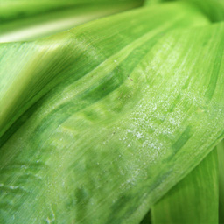

In [62]:
array_to_img(images[1])

In [65]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import tensorflow as tf

restnet = ResNet50(include_top=False, weights='imagenet', input_shape=(224,224,3)) # загружаем предобученную сеть

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
n_labels = le.fit_transform(labels)
y = to_categorical(n_labels)
y

In [98]:
labels_count = np.unique(n_labels).size
labels_count

16

## Сборка модели

In [90]:
output = restnet.layers[-1].output # используем выход пердыдущего слоя
output = tf.keras.layers.Flatten()(output) # видимо обертка
restnet = Model(restnet.input, outputs=[output]) # создаем это все дело как модель
for layer in restnet.layers: # замораживаем предобученные слои модели
    layer.trainable = False

In [99]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
model = Sequential() #  собираем сеть из предобученныз слов и полносвязных слоев с отсечением в 0.3
model.add(restnet)
model.add(Dense(512, activation='relu', input_dim=(100352)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(labels_count, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', # лейблы кодируются в one-hot
              optimizer=optimizers.RMSprop(lr=2e-5), # sgd с тюнингом
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 100352)            23587712  
_________________________________________________________________
dense_9 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                8208      
Total params: 75,239,312
Trainable params: 51,651,600
Non-trainable params: 23,587,712
_________________________________

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [101]:
from sklearn.model_selection import train_test_split
[X_train, X_test, y_train, y_test] = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=777)

## Обучение

In [102]:
history = model.fit(X_train, y_train,
                              steps_per_epoch=100, 
                              epochs=2,
                              validation_data=(X_test, y_test), 
                              validation_steps=50, 
                              verbose=1)

Epoch 1/2
100/100 [==============================] - 107s 1s/step - loss: 2.9099 - accuracy: 0.2817 - val_loss: 1.4106 - val_accuracy: 0.5319
Epoch 2/2
100/100 [==============================] - 89s 891ms/step - loss: 1.0544 - accuracy: 0.6536
